<a href="https://colab.research.google.com/github/mashrukh-zaman/BanglaNet/blob/main/BanglaNet_MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importing all the libraries required for our code
import numpy as np
import pandas as pd
import cv2
from pathlib import Path
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime,os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Input, Conv2D, Flatten, MaxPool2D, Activation,BatchNormalization,MaxPooling2D,Dropout
from tensorflow.keras.optimizers import Adam

#Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#defining the path to our data using the pathlib library
data_root = Path('/content/drive/My Drive/Desi imagenet')
print('data_root:', data_root) 

data_root: /content/drive/My Drive/Desi imagenet


In [ ]:
Dim = 256 #dimension of the image 
batch_size = 10 #batch size specified to be trained
Num_class = 13 #number of classes of the dataset

train_steps_per_epoch = 1420 // batch_size # // rounds up to lower number after division (floor division)
val_steps_per_epoch = 349 // batch_size
test_steps_per_epoch = 198 // batch_size

In [ ]:
datagen=ImageDataGenerator(rescale = 1./255, validation_split = 0.2) #0.2 basicallmy means,20 out 100 images will be used for validation and 80 of them will be used for training.

train_gen = datagen.flow_from_directory(data_root/'Train', target_size = (Dim, Dim),batch_size = 10,subset = 'training') #train_gen and val_gen is a set of images which will be called in later aspect of our code.
val_gen = datagen.flow_from_directory(data_root/'Train', target_size = (Dim, Dim), batch_size = 10,subset = 'validation') 

Found 1420 images belonging to 13 classes.
Found 349 images belonging to 13 classes.


[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


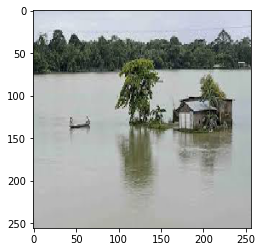

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


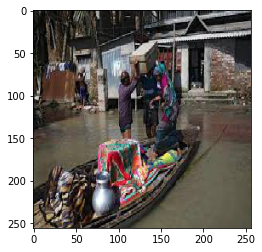

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


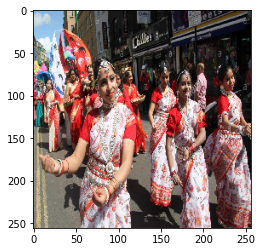

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


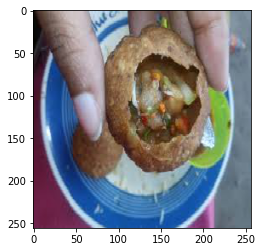

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


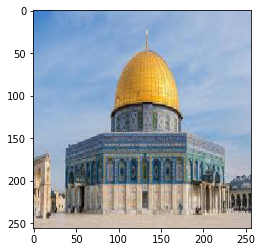

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


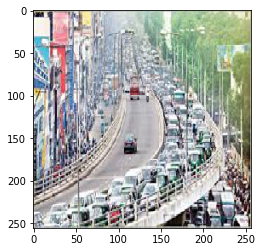

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


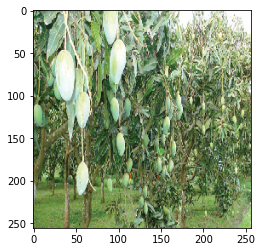

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


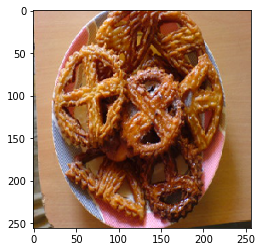

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


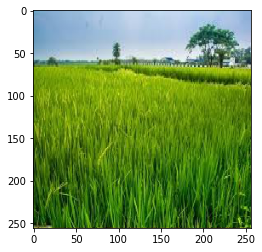

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


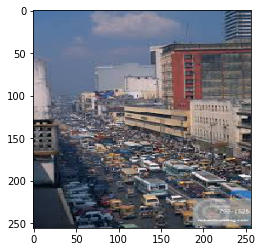

In [ ]:
x_batch,y_batch = next(train_gen)
for i in range (0,10):   
  image = x_batch[i]  
  plt.imshow(image)
  print(y_batch[i])
  plt.show()

In [ ]:
model = Sequential()                               #sequential network
mobilenet = MobileNetV2(include_top=False,         #wether to includ a fully connected layer at the top of the network
               weights='imagenet' ,                #using weights from a pre-trained model
               input_shape = (Dim, Dim, 3), 
               pooling='avg')
model.add(mobilenet)
model.add(Dense(64, kernel_regularizer = l2(0.001), activation = 'sigmoid'))
model.add(Dropout(0.25))
model.add(Dense(64, kernel_regularizer = l2(0.001),activation = 'sigmoid'))
model.add(Dropout(0.25))
model.add(Dense(Num_class, activation = 'softmax')) #Softmax converts a real vector to a vector of categorical probabilities.


print('finished loading model.')

9412608/9406464 [==============================] - 0s 0us/step
finished loading model.


In [ ]:
model.compile(optimizer = Adam(lr=3e-4),loss = 'categorical_crossentropy', metrics = ['accuracy']) #metrics = calculates how often predictions equal labels, loss =  becasue more than 2 classes, Learning rate controls how quickly or slowly a neural network model learns a problem

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 64)                81984     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 13)                845       
Total params: 2,344,973
Trainable params: 2,310,861
Non-trainable params: 34,112
_________________________________________

In [ ]:
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 10)

cb_checkpointer=ModelCheckpoint(filepath='/content/drive/My Drive/Desi imagenet/mobilenet.hdf5', #to save a model or weights at some interval
                               monitor = 'val_loss',
                               save_best_only = True,
                               mode = 'auto')

reducelr=ReduceLROnPlateau(monitor = 'val_loss',  # monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced
                           factor = 0.2, 
                           patience = 5, 
                           min_lr = 5e-4)

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1) #for visulization of the model characteristics of the dataset.

In [ ]:
fit_history=model.fit_generator(train_gen,steps_per_epoch = train_steps_per_epoch,
                                epochs = 50, validation_data=val_gen,
                                validation_steps = val_steps_per_epoch,
                                callbacks  =[cb_checkpointer,cb_early_stopper,reducelr, tensorboard_callback])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
  1/142 [..............................] - ETA: 0s - loss: 2.9276 - accuracy: 0.3000WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
 51/142 [=========>....................] - ETA: 4:57 - loss: 2.7019 - accuracy: 0.1627

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


142/142 [==============================] - 588s 4s/step - loss: 2.3952 - accuracy: 0.3458 - val_loss: 2.0300 - val_accuracy: 0.6941
Epoch 2/50
142/142 [==============================] - 22s 157ms/step - loss: 1.8856 - accuracy: 0.6563 - val_loss: 1.7699 - val_accuracy: 0.8324
Epoch 3/50
142/142 [==============================] - 22s 153ms/step - loss: 1.6266 - accuracy: 0.7683 - val_loss: 1.9232 - val_accuracy: 0.6029
Epoch 4/50
142/142 [==============================] - 22s 152ms/step - loss: 1.4200 - accuracy: 0.8359 - val_loss: 2.0799 - val_accuracy: 0.4618
Epoch 5/50
142/142 [==============================] - 23s 160ms/step - loss: 1.2137 - accuracy: 0.8965 - val_loss: 1.4503 - val_accuracy: 0.7382
Epoch 6/50
142/142 [==============================] - 22s 154ms/step - loss: 1.0377 - accuracy: 0.9352 - val_loss: 2.0941 - val_accuracy: 0.3559
Epoch 7/50
142/142 [==============================] - 22s 152ms/step - loss: 0.9327 - accuracy: 0.9401 - val_loss: 1.7598 - val_accuracy: 0.505

In [ ]:
%tensorboard --logdir logs #to visualize the tensorboard logs from the log directory

In [ ]:
model.load_weights('/content/drive/My Drive/Desi imagenet/mobilenet.hdf5') #loading the model weights that has been saved before
print('model weights loaded')

test_gen = datagen.flow_from_directory(data_root/'Test',
                                       target_size = (Dim,Dim),
                                       batch_size = 10,
                                       shuffle = False)

#test_gen.reset()
pred=model.predict_generator(test_gen,                                 #predicting the test data
                             steps = test_steps_per_epoch ,
                             verbose = 1)

predicted_class_indices = np.argmax(pred, axis = 1) #argmax takes the highest number from a row or a column which is defined by axis, here axis=1 means row
print(predicted_class_indices[89]) 

model weights loaded
Found 193 images belonging to 1 classes.
Instructions for updating:
Please use Model.predict, which supports generators.
19/19 [==============================] - 59s 3s/step
11


In [ ]:
score = model.evaluate(val_gen) #evaluting the model gives us the actual ratio of loss and accuracy 
print('Validation loss', score[0])
print('Validation accuracy', score[1])

35/35 [==============================] - 5s 145ms/step - loss: 0.2155 - accuracy: 0.9857
Validation loss 0.2154800295829773
Validation accuracy 0.9856733679771423
